---
title: Resultados da Avaliação
format: pdf
execute:
    echo: false
    warning: false
---

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from dotenv import dotenv_values
from os.path import abspath
# from sklearn.linear_model import LinearRegression


envVals = dotenv_values('../.env')

plt.rcParams['figure.figsize'] = (22, 16)
plt.rcParams['figure.titlesize'] = 30
plt.rcParams['axes.labelsize']  = 15
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['lines.linewidth'] = 4

plt.ion()

def despine(ax):
  # Hiding spines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  # Setting
  ax.yaxis.set_ticks_position('left')
  ax.xaxis.set_ticks_position('bottom')

In [58]:
# Abrindo indicadores em um DataFrame
dataPath = abspath('../data') + '/' + envVals['TICKER'] + '.json'
indicadoresDf = pd.read_json(dataPath)

# Abrindo histórico de cotações da ação em um segundo DataFrame
yahooTicker = envVals['TICKER'] + '.SA'

tk = yf.Ticker(yahooTicker)
tickerDf = tk.history('5y')


## Histórico de preços da ação

Demonstrativo de histórico de preços da ação nos períodos: 5 dias, 1 mês, 6 meses, 1 ano e 5 anos.

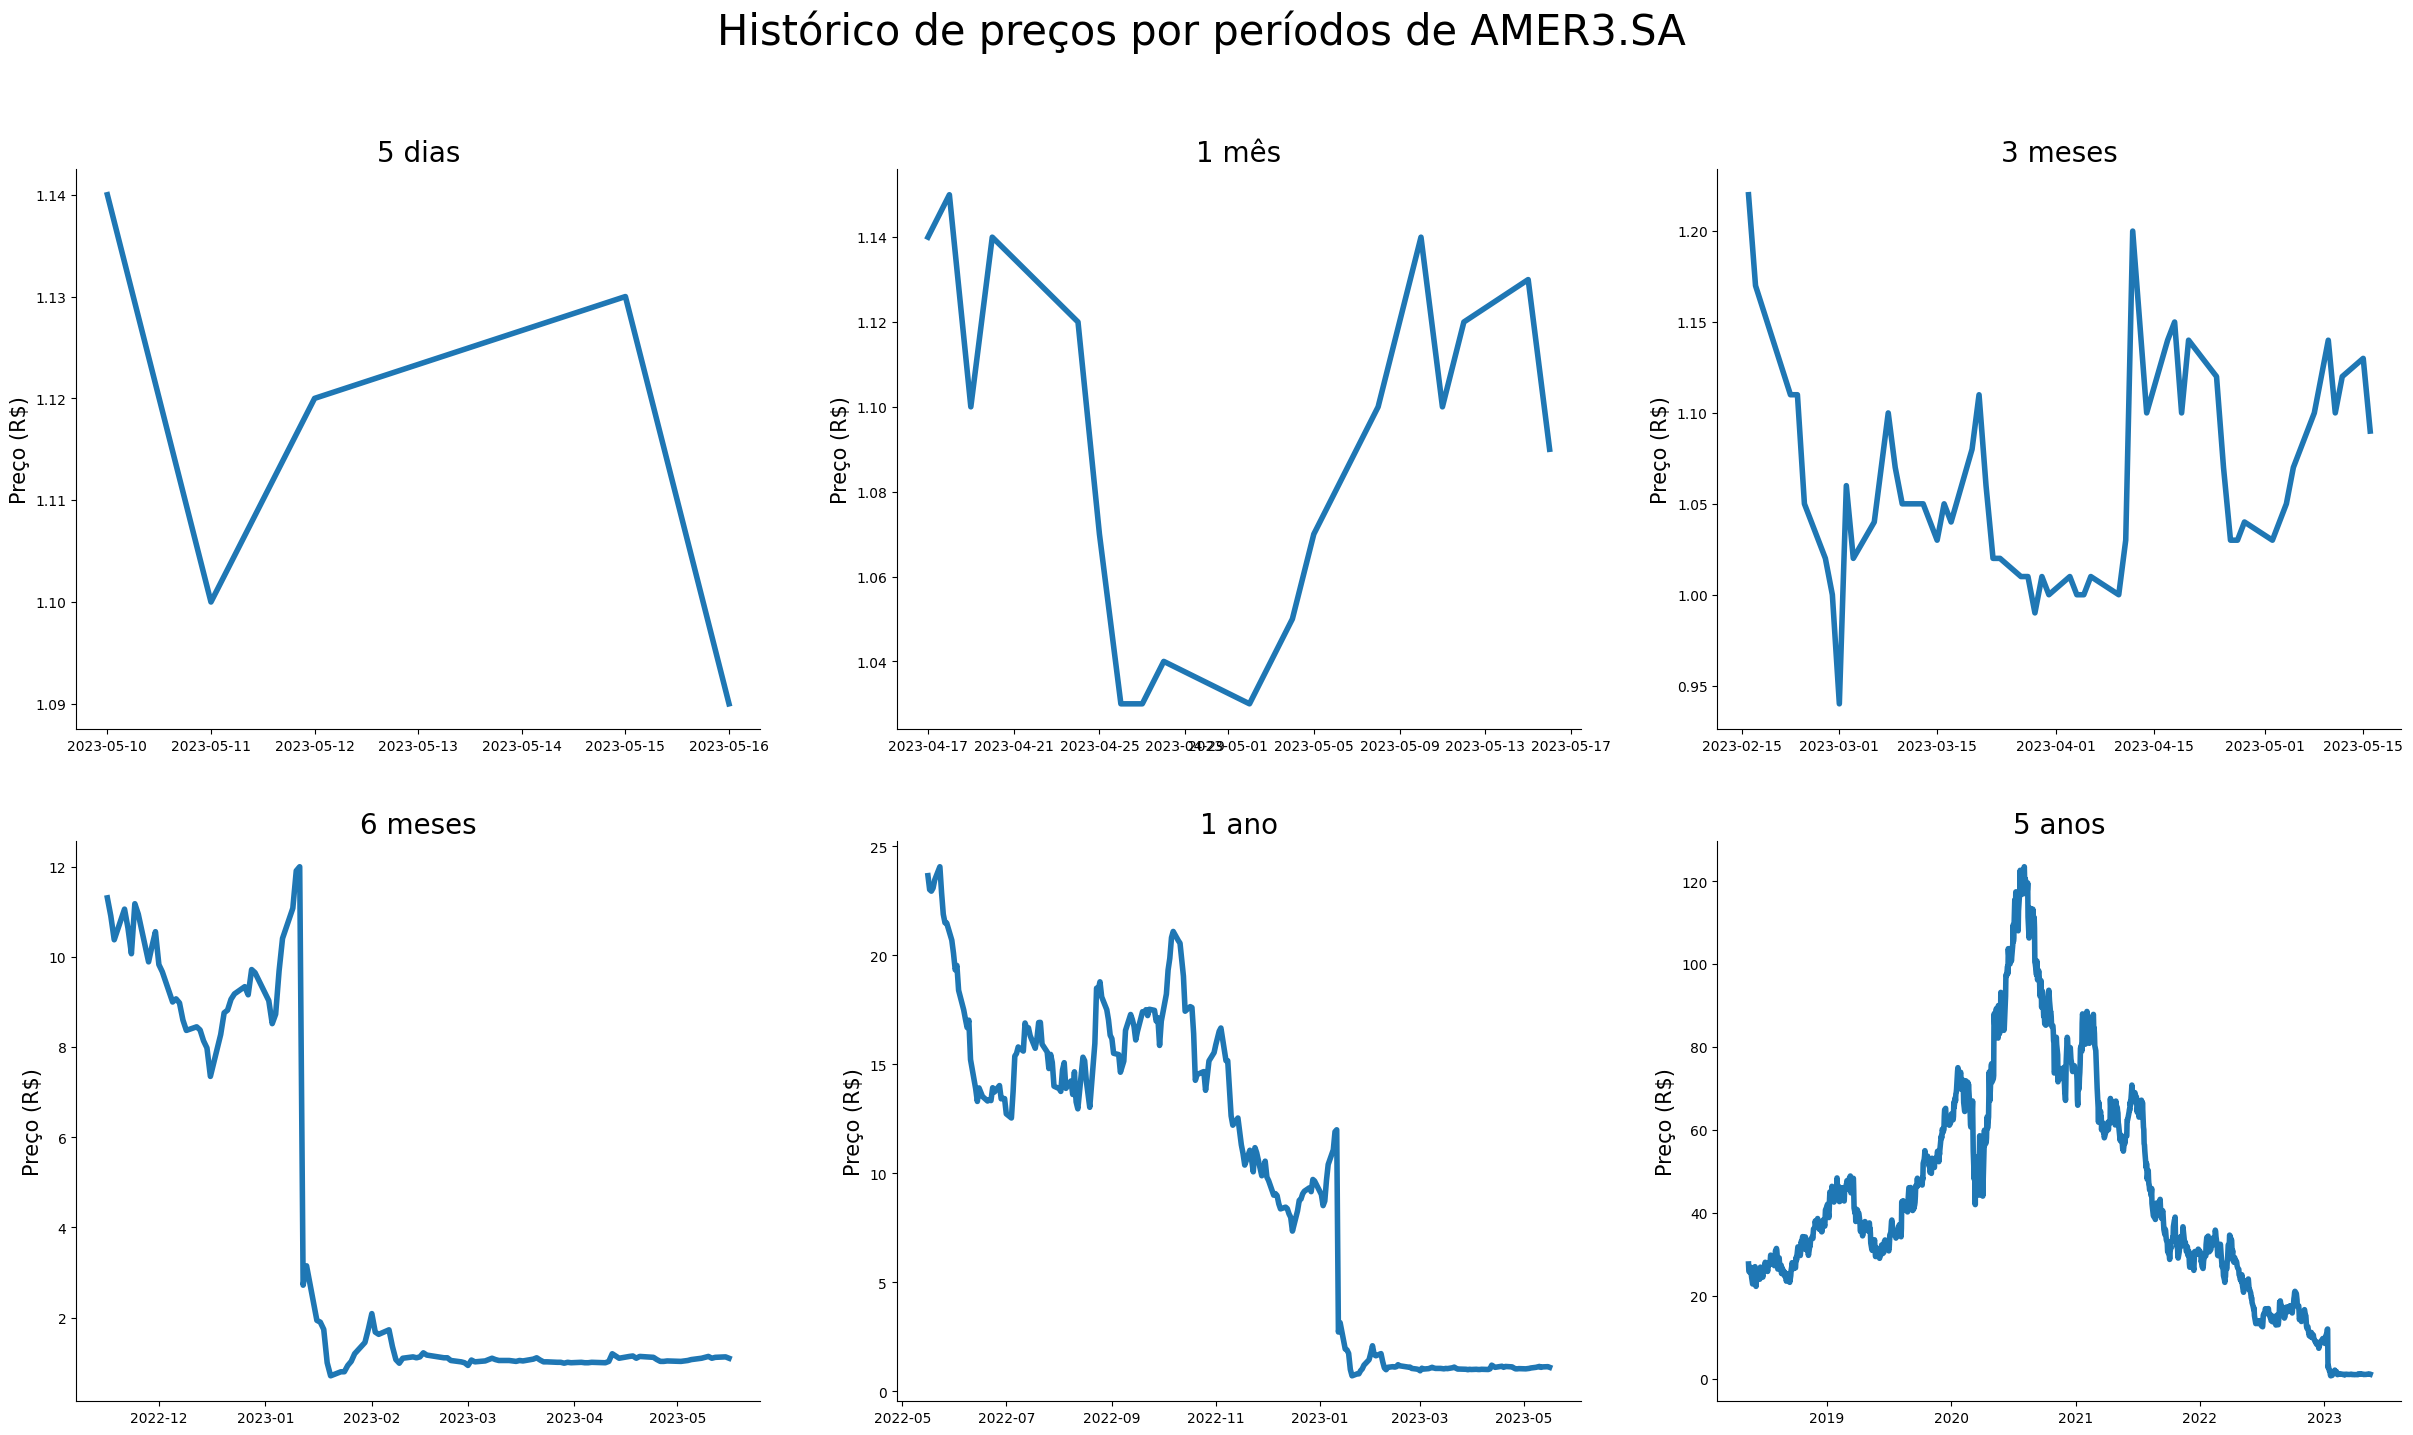

In [80]:
day5 = tk.history('5d')
m1 = tk.history('1mo')
m3 = tk.history('3mo')
m6 = tk.history('6mo')
y1 = tk.history('1y')
y5 = tk.history('5y')

dados = [day5['Close'], m1['Close'], m3['Close'], m6['Close'], y1['Close'], y5['Close']]

names = ['5 dias', '1 mês', '3 meses', '6 meses', '1 ano', '5 anos']

fig, vax = plt.subplots(2, 3)

fig.suptitle(f'Histórico de preços por períodos de {yahooTicker}')
fig.set_figwidth(30)

for ax, data, name in zip(vax.flat, dados, names):
    despine(ax)
    
    # data = data.to_frame().reset_index()
    # data['Date'] = pd.to_datetime(data['Date'])
    # data['Date'] = data['Date'].dt.strftime('%d/%m')
    # ax.plot(data['Date'], data['Close'])

    ax.set_title(name)
    ax.set_ylabel('Preço (R$)')
    
    ax.plot(data)


plt.show()

In [76]:
d = m6['Close'].to_frame().reset_index()

d['Date'] = pd.to_datetime(d['Date'])

d['Date'] = d['Date'].dt.strftime('%d/%m')

d

,Date,Close
0,16/11,11.31
1,17/11,10.91
2,18/11,10.38
3,21/11,11.06
4,22/11,10.64
...,...,...
119,10/05,1.14
120,11/05,1.10
121,12/05,1.12
122,15/05,1.13


## Histórico de Indicadores Fundamentalistas

Os gráficos à seguir tem a intenção de detalhar o histórico de alguns indicadores fundamentalistas referentes ao Ticker em questão. (P/L, DY, VPA, P/VP) 

In [ ]:
valores = [pd.DataFrame(indicadoresDf['P/L']['series']), pd.DataFrame(indicadoresDf['Dividend Yield']['series']),pd.DataFrame(indicadoresDf['VPA']['series']), pd.DataFrame(indicadoresDf['P/VP']['series'])]

indexes = ['P/L', 'Dividend Yield', 'VPA', 'P/VP']

fig, vax = plt.subplots(2, 2)

# fig.set_figwidth(18)
# fig.set_figwidth(18)

fig.suptitle(f'Indicadores Fundamentalistas {yahooTicker}', fontsize=24)

for ax, data, name in zip(vax.flat, valores, indexes):
    data['value'] = data['value'].fillna(0)
    despine(ax)
    ax.set_title(f'{name}')
    ax.plot(data['year'], data['value'])

    for i in range(len(data)):
        ax.text(data['year'][i], round(data['value'][i], 2), f'{data["value"][i]:.2f}' , size=12)


plt.show()

<Figure size 6600x4800 with 4 Axes>

## Margem EBIT comparada com Dívida Líquida/EBIT

Comparativo entre as margens de lucro da empresa com a Dívida líquida/EBIT. 

In [ ]:
ebitHist = pd.DataFrame(indicadoresDf['Dívida Líquida/EBIT']['series'])
ebit = pd.DataFrame(indicadoresDf['Margem EBIT']['series']).dropna()

fig, ax = plt.subplots()

fig.set_figheight(10)

ax.bar(ebit['year'], ebit['value'], color='lightgreen', label='Margem EBIT')
ax.axhline(y=0, linestyle='dashed', color='grey')

ax.plot(ebitHist['year'], ebitHist['value'], color='orange' ,label='Divida Líquida / EBIT')

for i in range(len(ebitHist)):
    ax.text(ebitHist['year'][i], round(ebitHist['value'][i], 2), f'{ebitHist["value"][i]:.2f}' , size=12, color='black')


for i in range(len(ebit)):
    ax.text(ebit['year'][i], (ebit['value'][i]), f'{ebit["value"][i]:.2f}' , size=12, color='green')

despine(ax)

ax.legend()

ax.set_title(f'Comparativo de dívida com EBIT {yahooTicker}')
fig.set_figwidth(20)
fig.show()

<Figure size 6000x3000 with 1 Axes>

## Indicadores de Reinvestimento da empresa:

Demonstrativo de indicadores de Reinvestimento e capacidade de crescimento da empresa. Os indicadores em questão são: 

In [ ]:
nomes = ['ROE', 'ROA', 'ROIC']
dados = []
colors = ['lightblue', 'bisque', 'lightgreen']

for i in nomes:
    dados.append(pd.DataFrame(indicadoresDf[i]['series']))

fig, vax = plt.subplots(1, 3)

for ax, name, data, c in zip(vax.flat, nomes, dados, colors):

    # Plotagem de informações
    ax.bar(data['year'], data['value'], color=c)

    # Texto com valores:
    for i in range(len(data['value'])):
        ax.text(data['year'][i], (data['value'][i] + 0.5), f'{data["value"][i]:.2f}' , size=8, rotation=45)

    # Definão de estilos
    ax.axhline(y=0, color='gray', linestyle='dashed')
    despine(ax)

    # Definição de Legedas:
    ax.set_title(name)
    ax.set_ylabel('Taxa de Retorno (%)')
    ax.set_xlabel('Ano')

fig.suptitle(f'Indicadores de Rentabilidade de {yahooTicker}')
fig.set_figwidth(20)
fig.show()

<Figure size 6000x4800 with 3 Axes>

## Cálculo do valor pelo método de Graham

O método de Graham utiliza de dois indicadores fundamentalistas: $LPA$ e $VPA$, para realizar o cálculo do "Valor Justo" de uma ação, ou seja, o valor que ela deveria ter de acordo com seus indicadores fundamentalistas. O cálculo é realizado através da seguinte fórmula:

$$
\sqrt{22.5 * LPA * VPA}
$$

Além disso, é calculada também uma margem de segurança em relação ao preço ideal de uma ação, que é um decréscimo de 15-30% do valor ideal. O valor de margem de segurança é subjetivo, e deve variar de acordo com a empresa.

In [ ]:
graham = np.sqrt(22.5 * indicadoresDf['VPA']['currentValue'] * indicadoresDf['LPA']['currentValue'])

safetyMargin = graham - float(envVals['SAFETY']) * graham
safetyMargin20 = graham - 0.2 * graham

safetypercent = float(envVals['SAFETY']) * 100

In [ ]:

fig, ax= plt.subplots(1, 1, constrained_layout =True)

# Plotando valor de Graham atual vs COtação
ax.axhline(y=graham, color='green', linestyle='dashed', label=f'Graham: R${graham:.2f}')

ax.axhline(y=safetyMargin, color='red', linestyle='dashed', label=f'Margem de segurança ({safetypercent}%): R${safetyMargin:.2f}')

ax.axhline(y=safetyMargin20, color='orange', linestyle='dashed', label=f'Margem de segurança (20.0%): R${safetyMargin20:.2f}')

ax.plot(tickerDf['Close'], label='Preço de fechamento')

despine(ax)

fig.suptitle(f"Análise de Graham {yahooTicker}")

ax.legend()

<Figure size 6600x4800 with 1 Axes>